# 📊 Bank Marketing Prediction  

**Internship Project – Developers Hub Corporation**  
**Intern:** *Ashna Imtiaz*  

---

## 🎯 Objective  
Predict whether a bank customer will subscribe to a term deposit as a result of a marketing campaign.  

---



### **Dataset Overview**

The dataset contains **17 features** related to client information and previous marketing campaigns:

| Column      | Description                                                                            |
| ----------- | -------------------------------------------------------------------------------------- |
| `age`       | Age of the client (numeric)                                                            |
| `job`       | Type of job (categorical)                                                              |
| `marital`   | Marital status (categorical: married, single, divorced)                                |
| `education` | Level of education (categorical: primary, secondary, tertiary)                         |
| `default`   | Has credit in default? (binary: yes/no)                                                |
| `balance`   | Average yearly balance (numeric, in euros)                                             |
| `housing`   | Has housing loan? (binary: yes/no)                                                     |
| `loan`      | Has personal loan? (binary: yes/no)                                                    |
| `contact`   | Contact communication type (categorical: cellular, telephone)                          |
| `day`       | Last contact day of the month (numeric)                                                |
| `month`     | Last contact month of year (categorical)                                               |
| `duration`  | Last contact duration, in seconds (numeric)                                            |
| `campaign`  | Number of contacts performed during this campaign (numeric)                            |
| `pdays`     | Days since last contact of previous campaign (-1 means not contacted before)           |
| `previous`  | Number of contacts performed before this campaign (numeric)                            |
| `poutcome`  | Outcome of previous marketing campaign (categorical: failure, success, other, unknown) |
| `y`         | Target variable: whether the client subscribed to a term deposit (binary: yes/no)      |

---

* `y = "yes"` → client subscribes
* `y = "no"` → client does not subscribe

This can help the bank **target potential clients more effectively**, reduce marketing costs, and improve campaign efficiency.


# Import required libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# For preprocessing & modeling
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# For downloading and unzipping the dataset
import urllib.request
import zipfile
import os

In [ ]:
#  Download and unzip bank marketing dataset

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip"
zip_path = "bank.zip"

# Download
urllib.request.urlretrieve(url, zip_path)

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("bank_data")

In [ ]:
# Load CSV into DataFrame
df = pd.read_csv("bank_data/bank-full.csv", sep=';')

print(f"Shape: {df.shape}")


Shape: (45211, 17)


In [ ]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [ ]:
df.sample(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
33772,32,blue-collar,single,secondary,no,228,no,no,telephone,23,apr,67,3,-1,0,unknown,no
22258,49,technician,divorced,secondary,no,57,no,no,cellular,21,aug,396,3,-1,0,unknown,no
29714,30,management,single,tertiary,no,179,no,no,cellular,3,feb,8,4,-1,0,unknown,no


# Data Visualization

### Distribution of Numeric Features

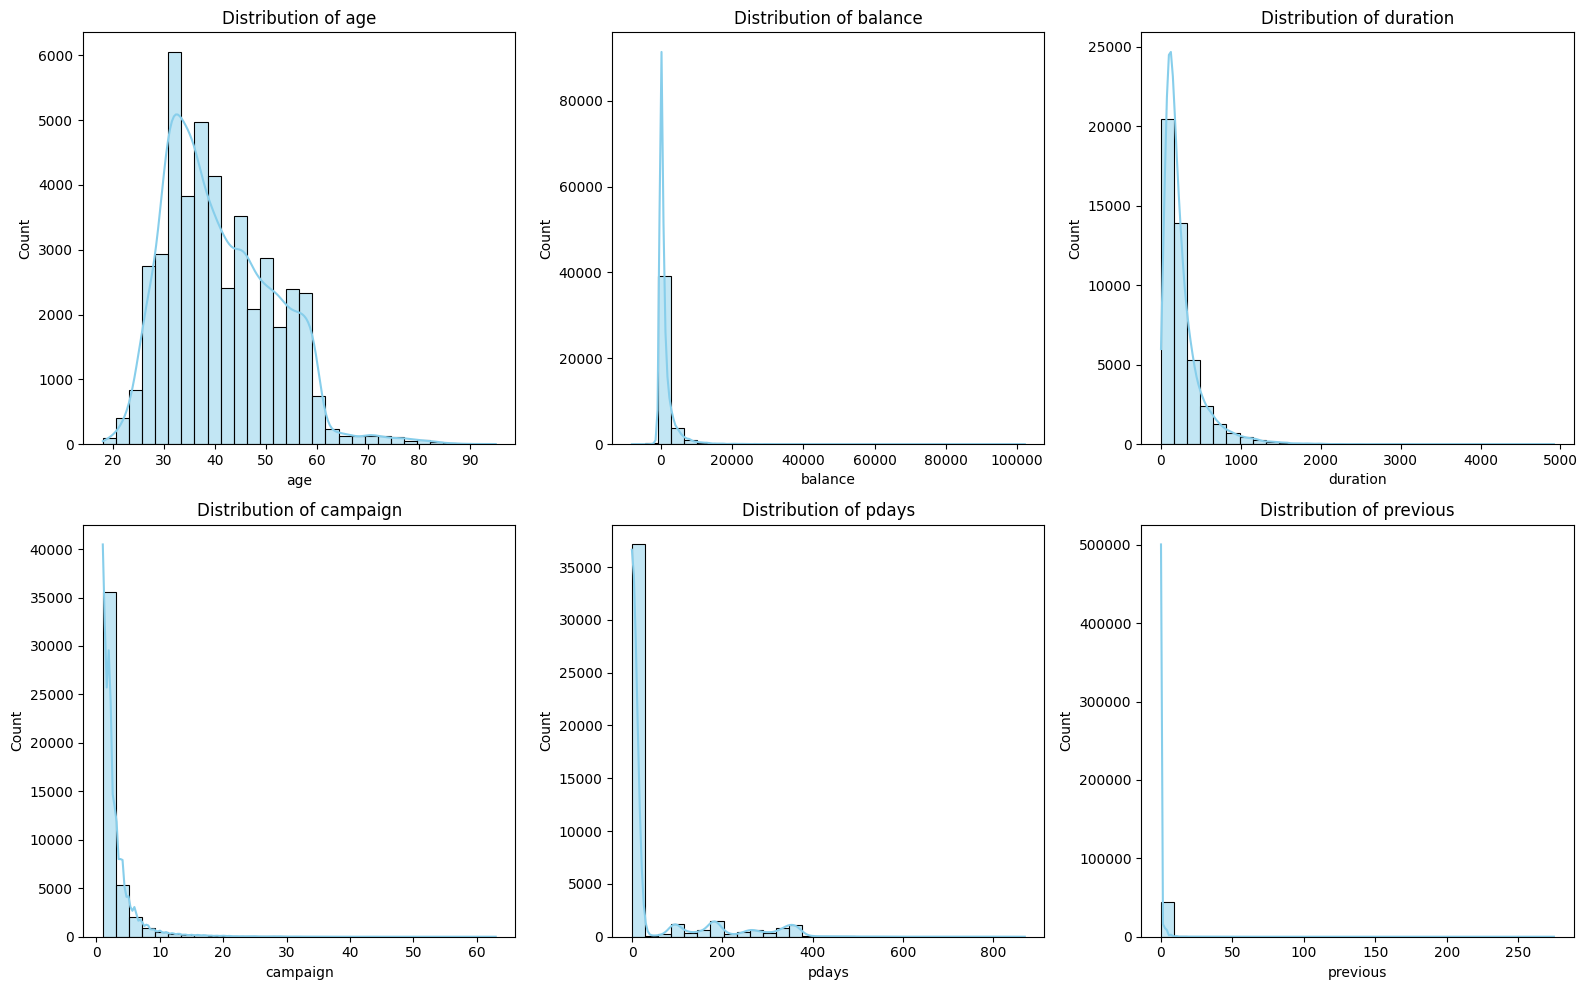

In [ ]:
numeric_features = ["age", "balance", "duration", "campaign", "pdays", "previous"]

plt.figure(figsize=(16,10))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(2,3,i)
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


### Categorical Feature Counts
Helps to see the balance of categories and rare values.

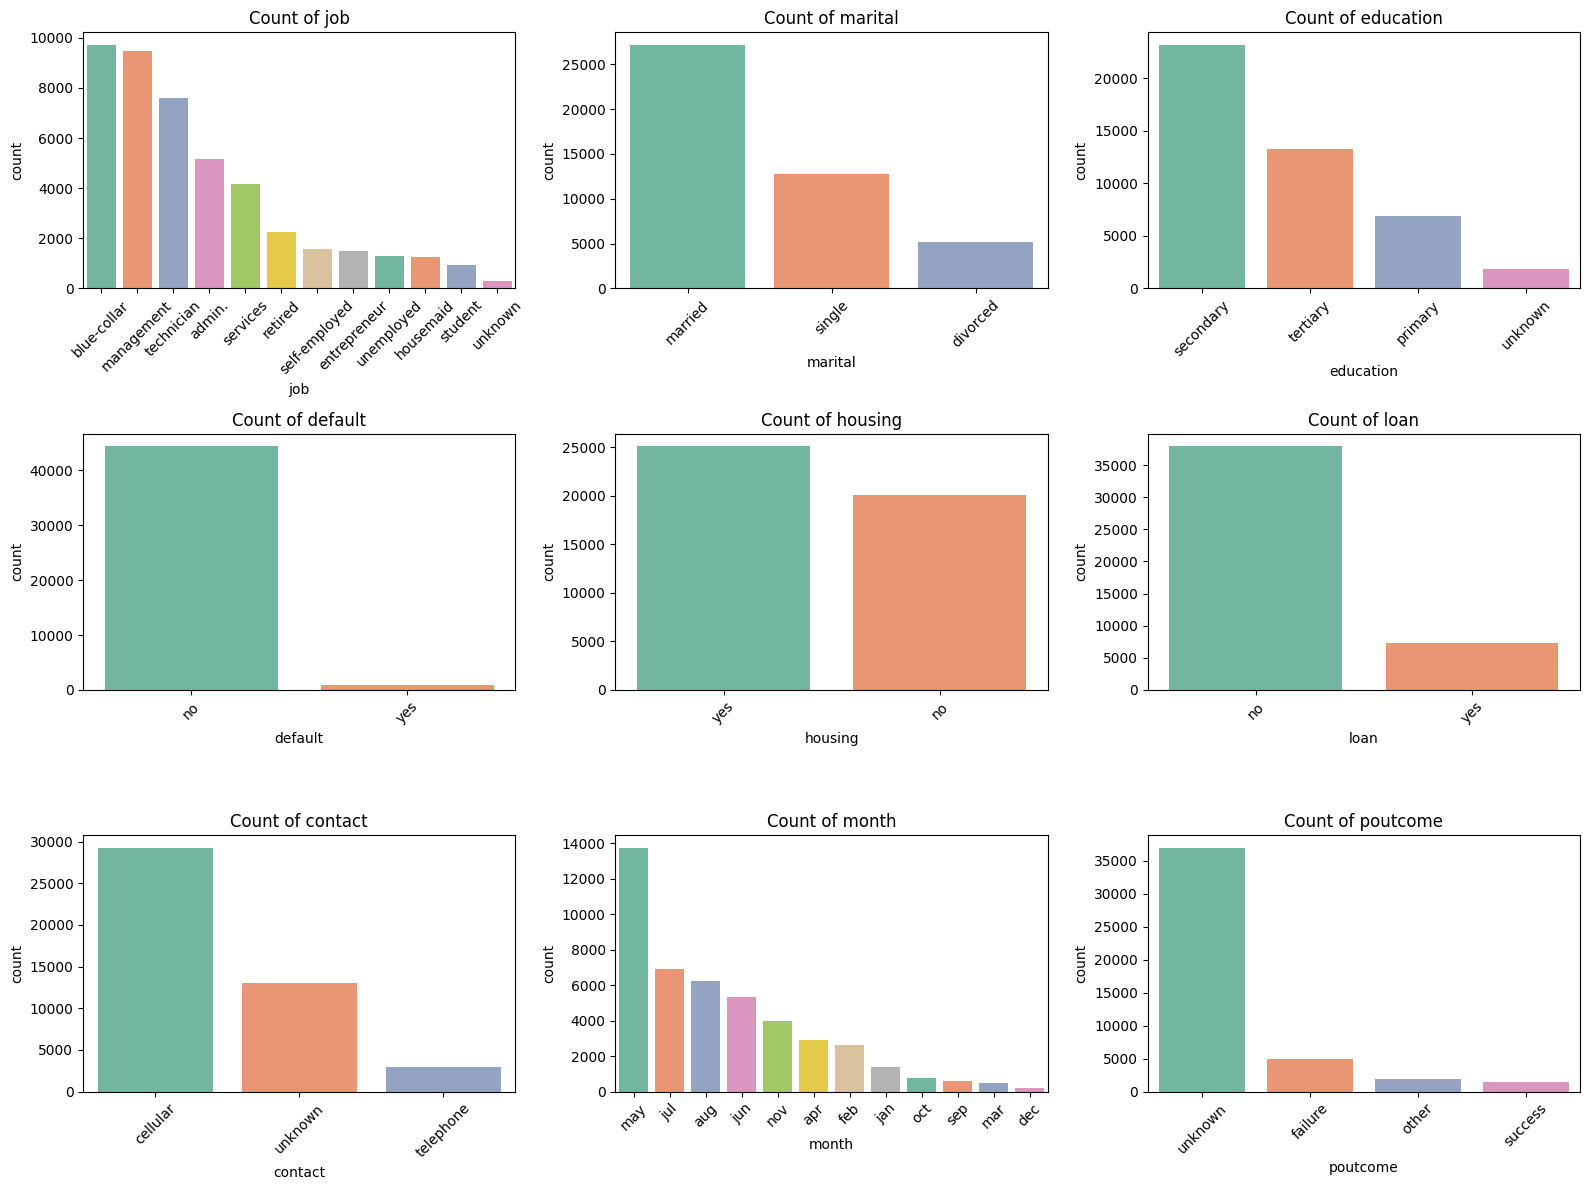

In [ ]:
categorical_features = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "poutcome"]

plt.figure(figsize=(16,12))
for i, col in enumerate(categorical_features, 1):
    plt.subplot(3,3,i)
    sns.countplot(x=col, data=df, palette="Set2", order=df[col].value_counts().index)
    plt.xticks(rotation=45)
    plt.title(f'Count of {col}')
plt.tight_layout()
plt.show()


## Target Variable Distribution
Check proportion of y (yes/no)


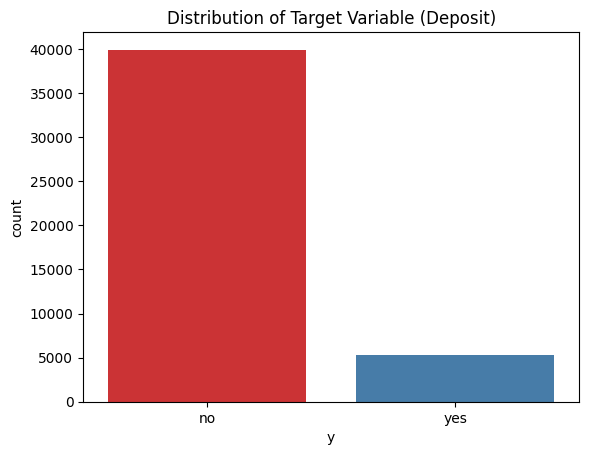

In [ ]:
sns.countplot(x='y', data=df, palette='Set1')
plt.title('Distribution of Target Variable (Deposit)')
plt.show()

In [ ]:
df['y'].value_counts(normalize=True)

,proportion
y,
no,0.883015
yes,0.116985


#  Relationship Between Job Type & Target

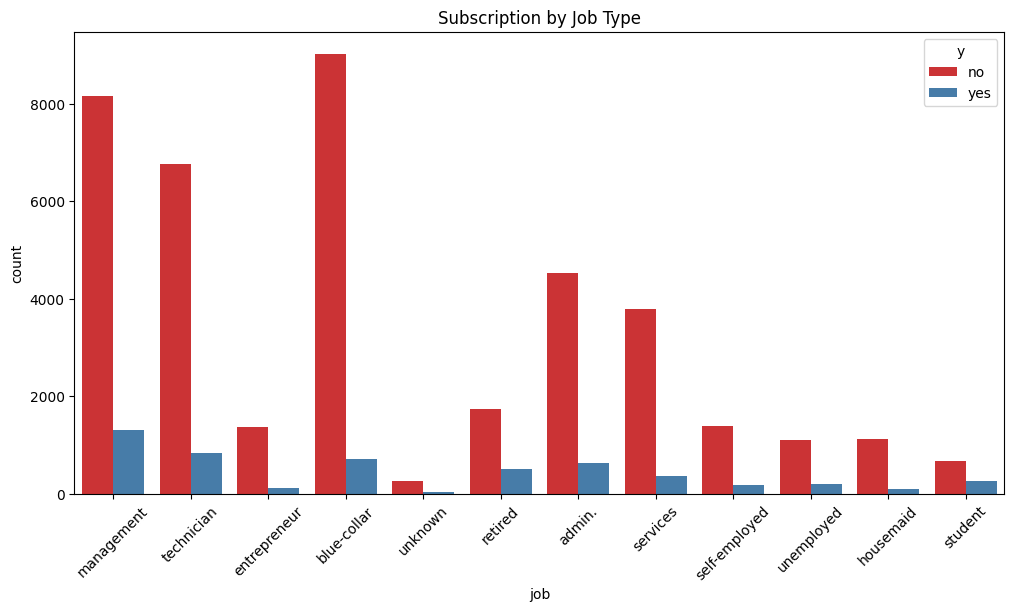

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x='job', hue='y', data=df, palette='Set1')
plt.xticks(rotation=45)
plt.title('Subscription by Job Type')
plt.show()



# Correlation Heatmap for Numeric Features
Helps to see relationships between numeric features and potential multicollinearity

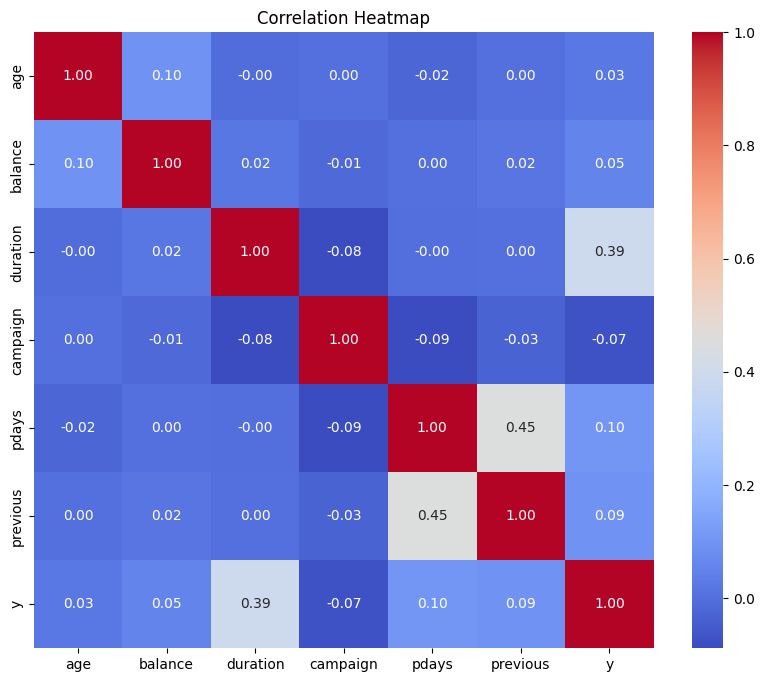

In [ ]:
df['y'] = df['y'].map({'no': 0, 'yes': 1})
plt.figure(figsize=(10,8))
sns.heatmap(df[numeric_features + ['y']].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()



#  Boxplots to Check Outliers vs Target


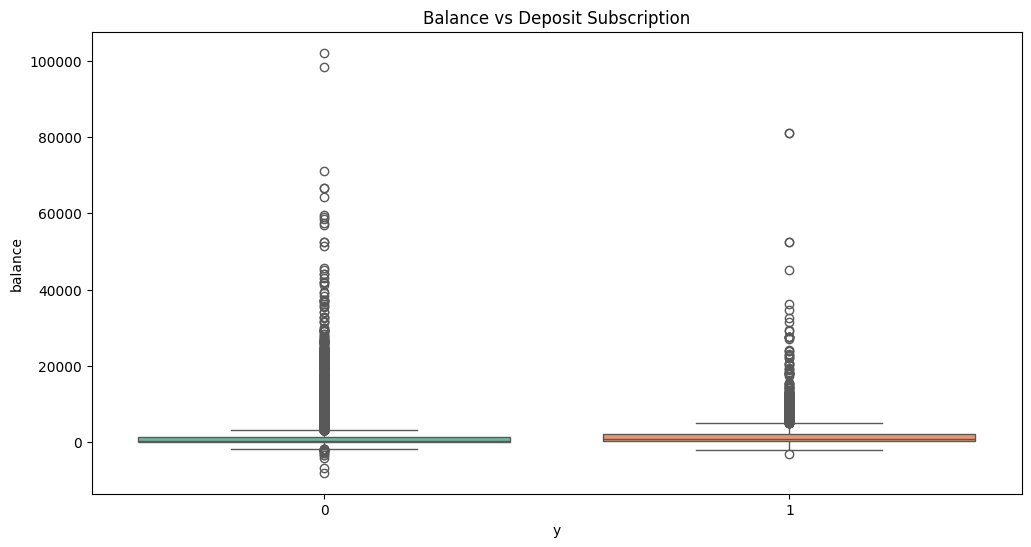

In [ ]:

plt.figure(figsize=(12,6))
sns.boxplot(x='y', y='balance', data=df, palette='Set2')
plt.title('Balance vs Deposit Subscription')
plt.show()

In [ ]:
df['balance'].skew()

np.float64(8.360308326166326)

In [ ]:
df['pdays'].skew()

np.float64(2.6157154736563477)

In [ ]:
df['previous'].skew()

np.float64(41.84645447266292)

# Handling Outliers and skewness
We handle skewness and outliers to ensure numeric features are well-behaved for modeling.

    Checks skewness for numeric columns.

    Applies log-transform only if the feature is highly skewed.

    Handles negative values before log-transform.

    Caps extreme outliers using IQR method.

In [ ]:
# Skewed numeric features
skewed_features = ["balance", "duration", "campaign"]

for col in skewed_features:
    # Shift if there are negative values
    min_val = df[col].min()
    if min_val <= 0:
        df[col] = df[col] - min_val + 1  # make all values positive
    df[col] = np.log1p(df[col])  # apply log1p safely

In [ ]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

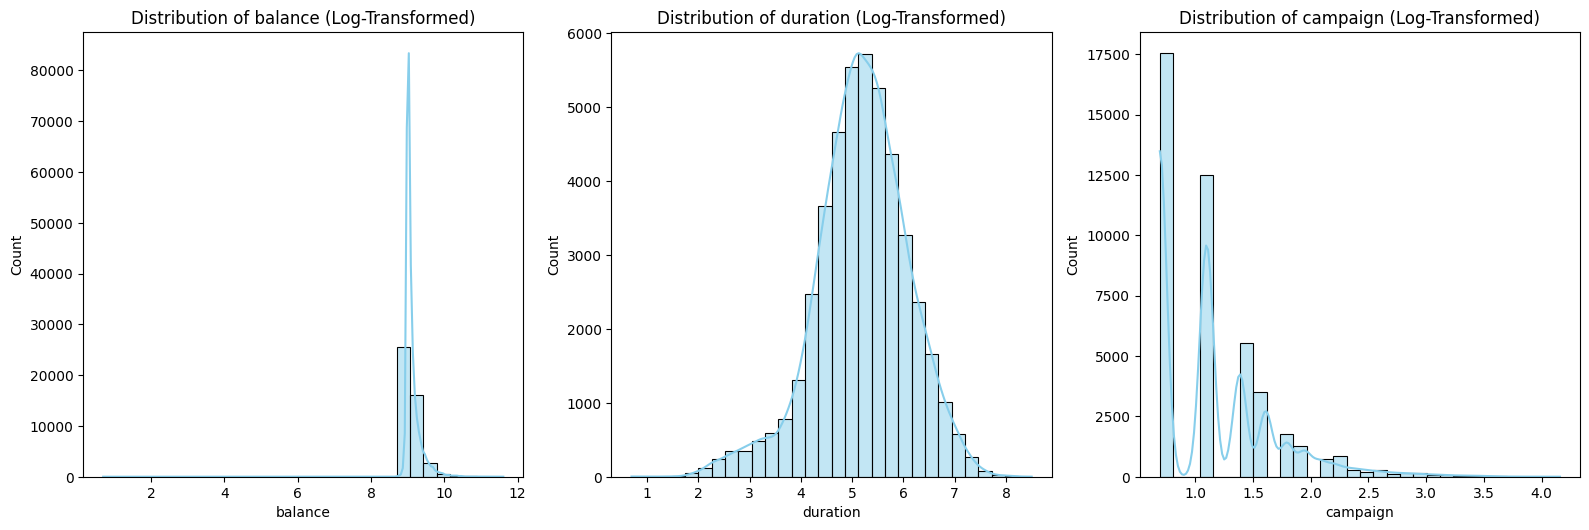

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Log-transformed numeric features
log_numeric_features = ["balance", "duration", "campaign"]

plt.figure(figsize=(16,10))
for i, col in enumerate(log_numeric_features, 1):
    plt.subplot(2,3,i)
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col} (Log-Transformed)')
plt.tight_layout()
plt.show()


Drop `duration` because it’s only known after the call, and including it would cause `data leakage`, making predictions unrealistic before contacting the client.


In [ ]:
df.drop(['duration'], inplace=True, axis=1)

In [ ]:
df['previous'].unique()

array([  0,   3,   1,   4,   2,  11,  16,   6,   5,  10,  12,   7,  18,
         9,  21,   8,  14,  15,  26,  37,  13,  25,  20,  27,  17,  23,
        38,  29,  24,  51, 275,  22,  19,  30,  58,  28,  32,  40,  55,
        35,  41])

In [ ]:
df['pdays'].unique()

## To Handle `previous` and `pdays` .
We apply binning on `previous` and `pdays` because they are sparse and highly skewed; log-transform collapses most values, losing information, while binning preserves meaningful categories for modeling.

In [ ]:
# Previous contact binning
# 0 → '0', 1 → '1', 2 or more → '2+'
df['previous_bin'] = pd.cut(
    df['previous'],
    bins=[-1,0,1,df['previous'].max()],
    labels=['0','1','2+']
)

# Pdays binning
# -1 → 'never contacted', 0–20 → 'recent', 21+ → 'long ago'
df['pdays_bin'] = pd.cut(
    df['pdays'],
    bins=[-2, -0.5, 20, df['pdays'].max()],
    labels=['never contacted','recent','long ago']
)

# Check value counts
print(df['previous_bin'].value_counts())
print(df['pdays_bin'].value_counts())


previous_bin
0     36954
2+     5485
1      2772
Name: count, dtype: int64
pdays_bin
never contacted    36954
long ago            8097
recent               160
Name: count, dtype: int64


In [ ]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'campaign', 'pdays', 'previous',
       'poutcome', 'y', 'previous_bin', 'pdays_bin'],
      dtype='object')

## Separate Features And Target

In [ ]:
# select features for modeling
X = df[['age', 'balance', 'campaign',
              'job', 'marital', 'education', 'default', 'housing', 'loan',
              'contact', 'month', 'poutcome',
              'previous_bin', 'pdays_bin']]

y = df['y']


In [ ]:
X.head()

,age,balance,campaign,job,marital,education,default,housing,loan,contact,month,poutcome,previous_bin,pdays_bin
0,58,9.226607,0.693147,management,married,tertiary,no,yes,no,unknown,may,unknown,0,never contacted
1,44,8.993427,0.693147,technician,single,secondary,no,yes,no,unknown,may,unknown,0,never contacted
2,33,8.990068,0.693147,entrepreneur,married,secondary,no,yes,yes,unknown,may,unknown,0,never contacted
3,47,9.161885,0.693147,blue-collar,married,unknown,no,yes,no,unknown,may,unknown,0,never contacted
4,33,8.989943,0.693147,unknown,single,unknown,no,no,no,unknown,may,unknown,0,never contacted


# Creating Pipelines

    We create two pipelines because different models have different requirements:

    Linear/distance-based models (Logistic Regression, SVM, KNN) need scaled numeric features and one-hot encoded categorical features to avoid misleading numeric relationships.

    Tree-based models (Random Forest, XGBoost) do not require scaling and can handle ordinal/label-encoded categorical features, making preprocessing simpler and more efficient.

    This ensures each model receives data in the format it can best learn from.

In [ ]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features

['age', 'balance', 'campaign']

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

categorical_features = df.select_dtypes(include='object').columns.tolist()
# 1) Pipeline for Logistic Regression, SVM, KNN
# Scale numeric + one-hot encode categorical
preprocessor_linear = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
])


#  Pipeline for Tree-based models (Random Forest, XGBoost)
# Only ordinal/label encode categorical; no scaling
preprocessor_tree = ColumnTransformer(transformers=[
    ('num', 'passthrough', numeric_features),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features)
])



# Split The Data into train and test set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [ ]:
X_train.shape, y_train.shape

((31647, 14), (31647,))

In [ ]:
X_test.head()

,age,balance,campaign,job,marital,education,default,housing,loan,contact,month,poutcome,previous_bin,pdays_bin
37735,40,9.104313,0.693147,blue-collar,divorced,secondary,no,no,no,cellular,may,unknown,0,never contacted
44332,35,9.008836,1.609438,unemployed,single,tertiary,no,no,no,cellular,jul,failure,2+,long ago
4432,38,9.077609,0.693147,self-employed,married,secondary,no,yes,no,unknown,may,unknown,0,never contacted
38725,35,9.015055,2.079442,blue-collar,married,secondary,no,yes,yes,cellular,may,failure,1,long ago
38581,44,9.054037,1.098612,services,single,secondary,no,yes,no,cellular,may,failure,2+,long ago


# Apply SMOTE to OverSample Minority Class

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
smote = SMOTE(random_state=42)

linear_pipeline_smote = ImbPipeline(steps=[
    ('preprocessor', preprocessor_linear),
    ('smote', smote),  # oversample minority
    ('classifier', LogisticRegression(max_iter=100, C=.007))
])

In [ ]:
# Train and evaluate
linear_pipeline_smote.fit(X_train, y_train)
y_pred_linear = linear_pipeline_smote.predict(X_test)


print("Logistic Regression with SMOTE")
print(classification_report(y_test, y_pred_linear))

Logistic Regression with SMOTE
              precision    recall  f1-score   support

           0       0.94      0.74      0.83     11977
           1       0.26      0.66      0.37      1587

    accuracy                           0.73     13564
   macro avg       0.60      0.70      0.60     13564
weighted avg       0.86      0.73      0.78     13564



`Pros:`
Catches a lot of positive cases (recall = 0.66) → meaning it finds many of those rare customers who say yes.

`Cons:`
Many false alarms (low precision = 0.26) → so out of all people it says will subscribe, most won’t actually subscribe.

Lower overall accuracy (0.73).

👉 Useful if your main goal is not to miss potential subscribers (you’d rather call more people, even if many are not interested).

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Pass class_weight='balanced' to handle imbalance
tree_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_tree),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

# Train and evaluate
tree_model_pipeline.fit(X_train, y_train)
y_pred_tree = tree_model_pipeline.predict(X_test)
print("Random Forest with class weights")
print(classification_report(y_test, y_pred_tree))

Random Forest with class weights
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     11977
           1       0.61      0.19      0.29      1587

    accuracy                           0.89     13564
   macro avg       0.76      0.59      0.62     13564
weighted avg       0.87      0.89      0.86     13564



`Pros:`
Very good at saying “no” correctly (recall for class 0 = 0.98).

High accuracy overall (0.89).

More balanced precision (0.61) for “yes” predictions.

`Cons:`
Weak recall for “yes” (0.19) → it misses most actual subscribers.

Good accuracy is misleading here because it’s mostly correct about the majority class (no).

👉 Useful if your main goal is to avoid wasting effort on uninterested customers, but you will miss most of the actual subscribers.

# Tune Hyperparameters

Logistic Regression

In [ ]:
linear_pipeline_smote = ImbPipeline(steps=[
    ('preprocessor', preprocessor_linear),
    ('smote', SMOTE(sampling_strategy=0.5, random_state=42)),
    ('classifier', LogisticRegression(
        max_iter=500,
        C=0.01,                 # weaker regularization
        penalty='l2',
        class_weight='balanced',
        solver='lbfgs'
    ))
])


In [ ]:
# Train and evaluate
linear_pipeline_smote.fit(X_train, y_train)
y_pred_linear = linear_pipeline_smote.predict(X_test)


print("Logistic Regression with SMOTE")
print(classification_report(y_test, y_pred_linear))

Logistic Regression with SMOTE
              precision    recall  f1-score   support

           0       0.94      0.75      0.83     11977
           1       0.26      0.66      0.37      1587

    accuracy                           0.74     13564
   macro avg       0.60      0.71      0.60     13564
weighted avg       0.86      0.74      0.78     13564



Random Forest classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

tree_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_tree),
    ('classifier', RandomForestClassifier(
        n_estimators=100,          # still reasonable
        max_depth=12,             # slightly deeper to learn patterns
        min_samples_leaf=2,       # allow smaller leaves for minority class
        class_weight='balanced_subsample', # more fine-grained balancing
        max_features='sqrt',      # faster + diverse trees
        n_jobs=-1,
        random_state=42
    ))
])


In [ ]:

# Train & evaluate
tree_model_pipeline.fit(X_train, y_train)
y_pred_fast_tree = tree_model_pipeline.predict(X_test)

print("Fast Random Forest with class weights")
print(classification_report(y_test, y_pred_fast_tree))

Fast Random Forest with class weights
              precision    recall  f1-score   support

           0       0.94      0.86      0.89     11977
           1       0.34      0.56      0.42      1587

    accuracy                           0.82     13564
   macro avg       0.64      0.71      0.66     13564
weighted avg       0.87      0.82      0.84     13564



# Now Train Xg-Boost Classifier

In [ ]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

# Adjusted XGBoost model pipeline
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_tree),
    ('classifier', XGBClassifier(
        n_estimators=500,          # more trees (better generalization)
        learning_rate=0.03,        # slower learning, more precise
        max_depth=4,               # shallower trees to avoid overfitting
        min_child_weight=3,        # control leaf size (reduce false positives)
        subsample=0.9,             # more samples per tree
        colsample_bytree=0.9,      # more features per tree
        gamma=1,                   # force splits only if gain is meaningful
        reg_alpha=0.1,             # L1 regularization
        reg_lambda=1.0,            # L2 regularization
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]), # imbalance handling
        random_state=42,
        use_label_encoder=False,
        eval_metric='aucpr'
    ))
])

# Train
xgb_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['age', 'balance',
                                                   'campaign']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=Non...
                               feature_types=None, feature_weights=None,
                               gamma=1, grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.03,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None, min_child_weight=3,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=500,
                               n_jobs=None, num_parallel_tree=None, ...))])

In [ ]:
# prediction
y_pred_xgb = xgb_pipeline.predict(X_test)

print("XGBoost Results:")
print(classification_report(y_test, y_pred_xgb))



XGBoost Results:
              precision    recall  f1-score   support

           0       0.94      0.82      0.87     11977
           1       0.31      0.63      0.42      1587

    accuracy                           0.79     13564
   macro avg       0.63      0.72      0.65     13564
weighted avg       0.87      0.79      0.82     13564



In [ ]:
from sklearn.metrics import recall_score, accuracy_score, classification_report

# Probabilities
y_pred_proba_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

# Default predictions (threshold = 0.5)
y_pred_xgb = (y_pred_proba_xgb >= 0.5).astype(int)

# Metrics
recall = recall_score(y_test, y_pred_xgb)
acc = accuracy_score(y_test, y_pred_xgb)

print("🔹 XGBoost Results (threshold=0.5)")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {acc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))


🔹 XGBoost Results (threshold=0.5)
Recall: 0.6263
Accuracy: 0.7939

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.82      0.87     11977
           1       0.31      0.63      0.42      1587

    accuracy                           0.79     13564
   macro avg       0.63      0.72      0.65     13564
weighted avg       0.87      0.79      0.82     13564



In [ ]:
# Adjust threshold for higher recall
threshold = 0.54
y_pred_xgb_custom = (y_pred_proba_xgb >= threshold).astype(int)

recall_custom = recall_score(y_test, y_pred_xgb_custom)
acc_custom = accuracy_score(y_test, y_pred_xgb_custom)

print(f"\n🔹 XGBoost Results (threshold={threshold})")
print(f"Recall: {recall_custom:.4f}")
print(f"Accuracy: {acc_custom:.4f}")



🔹 XGBoost Results (threshold=0.54)
Recall: 0.5841
Accuracy: 0.8273


# ROC-AUC Curve

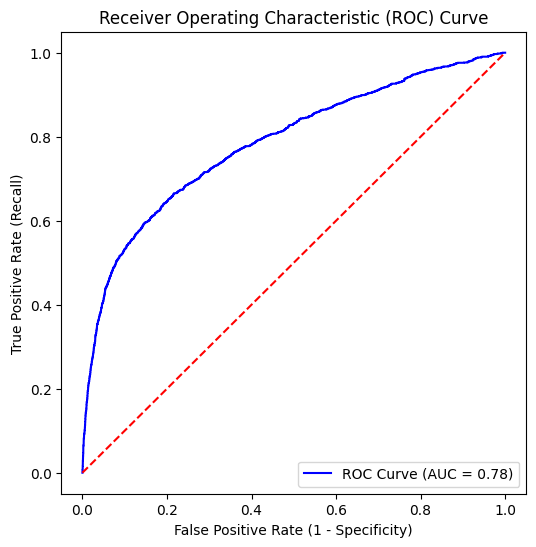

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_xgb)

# Compute ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba_xgb)

# Plot ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='red', linestyle='--')  # diagonal line
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


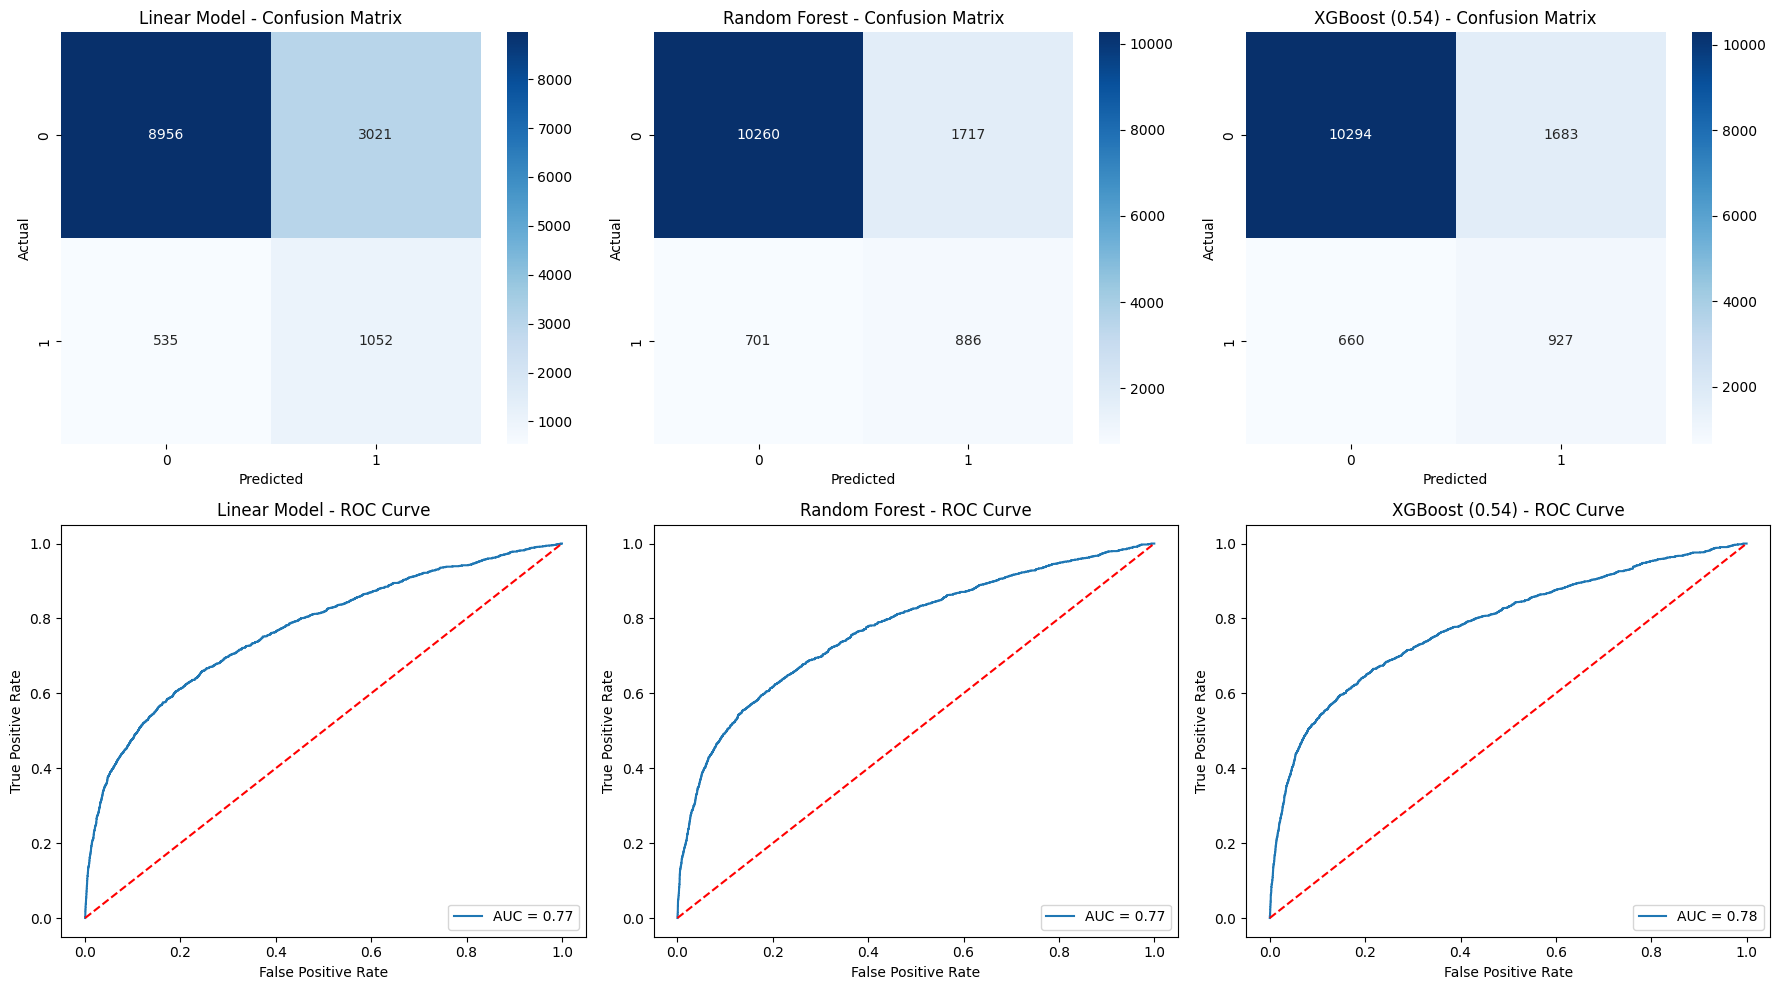

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Define function
def plot_all_models(y_true, preds, probs, model_names):
    fig, axes = plt.subplots(2, len(preds), figsize=(6*len(preds), 10))

    for i, (y_pred, y_prob, name) in enumerate(zip(preds, probs, model_names)):
        # --- Confusion Matrix ---
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0, i])
        axes[0, i].set_title(f"{name} - Confusion Matrix")
        axes[0, i].set_xlabel("Predicted")
        axes[0, i].set_ylabel("Actual")

        # --- ROC Curve ---
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = roc_auc_score(y_true, y_prob)
        axes[1, i].plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
        axes[1, i].plot([0, 1], [0, 1], linestyle="--", color="red")
        axes[1, i].set_title(f"{name} - ROC Curve")
        axes[1, i].set_xlabel("False Positive Rate")
        axes[1, i].set_ylabel("True Positive Rate")
        axes[1, i].legend(loc="lower right")

    plt.tight_layout()
    plt.show()


# ✅ Prepare predictions for your 3 models
y_pred_fast_tree = tree_model_pipeline.predict(X_test)
y_pred_linear = linear_pipeline_smote.predict(X_test)

# Probabilities needed for ROC curve
y_prob_fast_tree = tree_model_pipeline.predict_proba(X_test)[:,1]
y_prob_linear = linear_pipeline_smote.predict_proba(X_test)[:,1]

# XGBoost with custom threshold
threshold = 0.54
y_pred_xgb_custom = (y_pred_proba_xgb >= threshold).astype(int)

# Call function
plot_all_models(
    y_test,
    preds=[y_pred_linear, y_pred_fast_tree, y_pred_xgb_custom],
    probs=[y_prob_linear, y_prob_fast_tree, y_pred_proba_xgb],
    model_names=["Linear Model", "Random Forest", "XGBoost (0.54)"]
)


I selected the XGBoost model with threshold = 0.54 because it provides a balanced trade-off between recall (0.5841) and accuracy (0.8273). The slightly lowered threshold helps the model capture more positive cases (improving recall) without a drastic drop in overall accuracy, making it more reliable for identifying the target class while still maintaining strong general performance.

## 🔍 `Explaining Model Predictions with SHAP`

To better understand **why our XGBoost model makes certain predictions**, we used **SHAP (SHapley Additive exPlanations)**.  

### Steps:
1. Created a `TreeExplainer` for our trained XGBoost model.  
2. Selected the **first 5 samples** from the test set.  
3. Computed SHAP values, which quantify how each feature contributes to a prediction.  
4. Visualized the results with `shap.waterfall`, showing feature impact for each prediction.


🔎 Explaining prediction 1


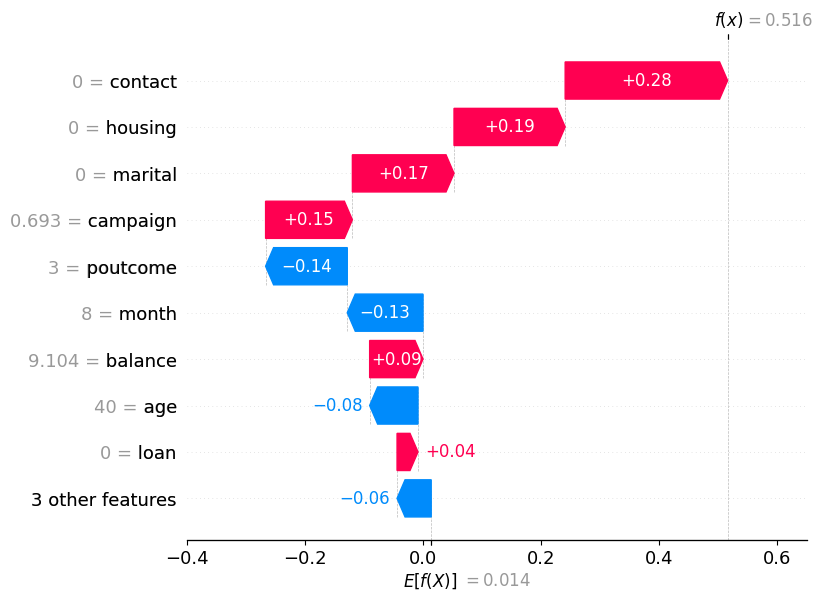


🔎 Explaining prediction 2


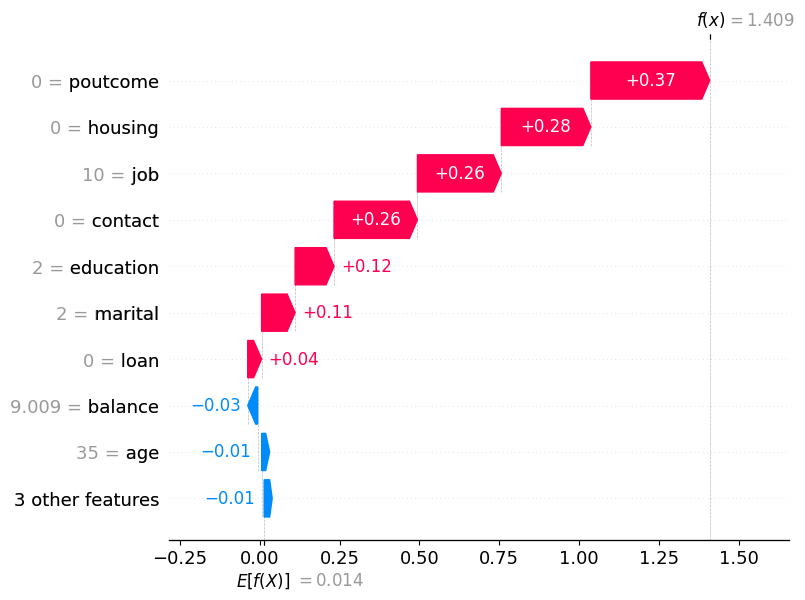


🔎 Explaining prediction 3


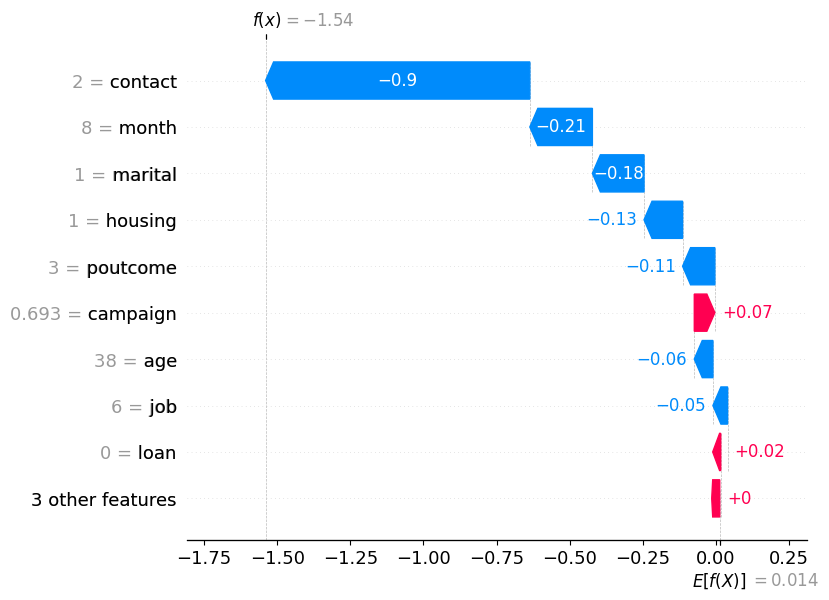


🔎 Explaining prediction 4


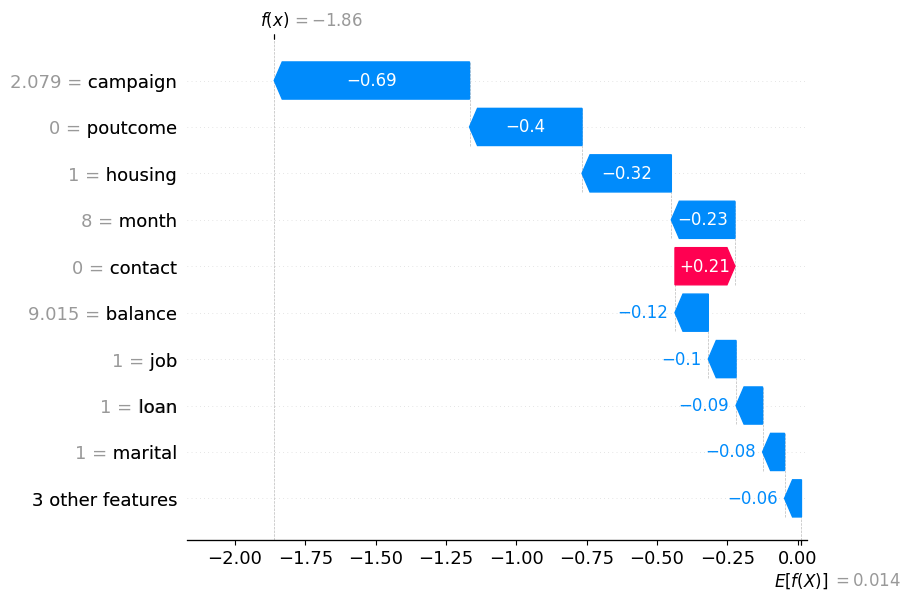


🔎 Explaining prediction 5


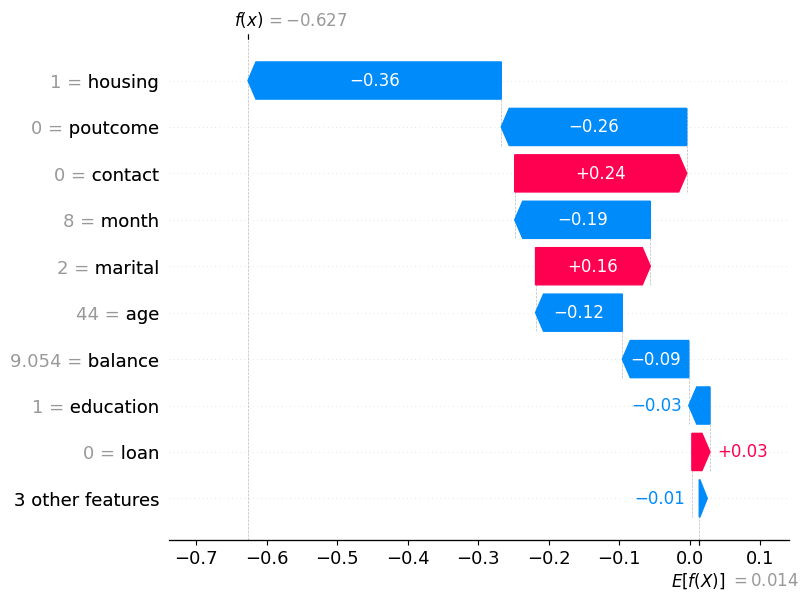

In [ ]:
import shap
import matplotlib.pyplot as plt

# ✅ Fit pipeline
xgb_pipeline.fit(X_train, y_train)

# ✅ Separate preprocessor & model
preprocessor = xgb_pipeline.named_steps['preprocessor']
model = xgb_pipeline.named_steps['classifier']

# ✅ Transform the test set
X_test_transformed = preprocessor.transform(X_test)

# ✅ Feature names
feature_names = numeric_features + categorical_features

# ✅ Create SHAP explainer
explainer = shap.TreeExplainer(model)

# ✅ Compute SHAP values
shap_values = explainer.shap_values(X_test_transformed)

# ✅ Pick 5 predictions and explain them
for i in range(5):
    print(f"\n🔎 Explaining prediction {i+1}")
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values[i],
            base_values=explainer.expected_value,
            data=X_test_transformed[i],
            feature_names=feature_names
        )
    )
    plt.show()


Save the model

In [ ]:
import joblib

# ✅ Save trained pipeline (preprocessor + XGBoost model together)
joblib.dump(xgb_pipeline, "bank_xgb_pipeline.pkl")
print("✅ Pipeline saved successfully!")

# ------------------------------
# Later, when you need to use it:
# ------------------------------

# # Load pipeline
# loaded_pipeline = joblib.load("bank_xgb_pipeline.pkl")

# # Make predictions directly (no need to transform separately)
# y_pred_loaded = loaded_pipeline.predict(X_test)

# print("🔹 Predictions with loaded pipeline done!")


✅ Pipeline saved successfully!
